In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
sys.path.append("..")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sceneclassification.config import *
from sceneclassification.datasets import SceneEmbeddingDataset
from sceneclassification.models.late_fusion_shallow import LateFusionShallow
from sceneclassification.train import train_epoch, eval_epoch
from sceneclassification.eval import evaluate

In [26]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [27]:
# Load Data
CSV_PATH = "../data/clip_embeddings_sunrgbd_with_labels.csv"

dataset = SceneEmbeddingDataset(CSV_PATH)
num_classes = dataset.num_classes
print("Num classes:", num_classes)

Num classes: 24


## Prepare Data

In [28]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Train samples: 1108
Val samples: 277


In [29]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## Model Initialization

In [30]:
model = LateFusionShallow(
    img_dim=IMAGE_EMB_DIM,
    depth_dim=DEPTH_EMB_DIM,
    text_dim=TEXT_EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=num_classes,
).to(DEVICE)

print(model)

LateFusionShallow(
  (fc): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=24, bias=True)
  )
)


## Training

In [31]:
# Optimizer and Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
)

In [ ]:
train_accs, val_accs = [], []

best_val_acc = 0.0
patience = 5
counter = 0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, DEVICE)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0  # reset counter if validation improves
        torch.save(model.state_dict(), "../model_assets/best_model_latefusionshallow.pth")  # save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"No improvement in validation accuracy for {patience} epochs. Stopping early.")
            break


Epoch 1/50 | Train Acc: 0.5560 | Val Acc: 0.5895
Epoch 2/50 | Train Acc: 0.6209 | Val Acc: 0.6243
Epoch 3/50 | Train Acc: 0.6688 | Val Acc: 0.6678
Epoch 4/50 | Train Acc: 0.7148 | Val Acc: 0.7025
Epoch 5/50 | Train Acc: 0.7671 | Val Acc: 0.7703
Epoch 6/50 | Train Acc: 0.7978 | Val Acc: 0.7912
Epoch 7/50 | Train Acc: 0.8375 | Val Acc: 0.8156
Epoch 8/50 | Train Acc: 0.8529 | Val Acc: 0.8399
Epoch 9/50 | Train Acc: 0.8664 | Val Acc: 0.8504
Epoch 10/50 | Train Acc: 0.8863 | Val Acc: 0.8434
Epoch 11/50 | Train Acc: 0.8953 | Val Acc: 0.8816
Epoch 12/50 | Train Acc: 0.9079 | Val Acc: 0.8816
Epoch 13/50 | Train Acc: 0.9152 | Val Acc: 0.8920
Epoch 14/50 | Train Acc: 0.9278 | Val Acc: 0.8955
Epoch 15/50 | Train Acc: 0.9278 | Val Acc: 0.8955
Epoch 16/50 | Train Acc: 0.9368 | Val Acc: 0.8920
Epoch 17/50 | Train Acc: 0.9404 | Val Acc: 0.8955
Epoch 18/50 | Train Acc: 0.9504 | Val Acc: 0.8920
Epoch 19/50 | Train Acc: 0.9567 | Val Acc: 0.9024
Epoch 20/50 | Train Acc: 0.9567 | Val Acc: 0.8990
Epoch 21/

## Evaluation

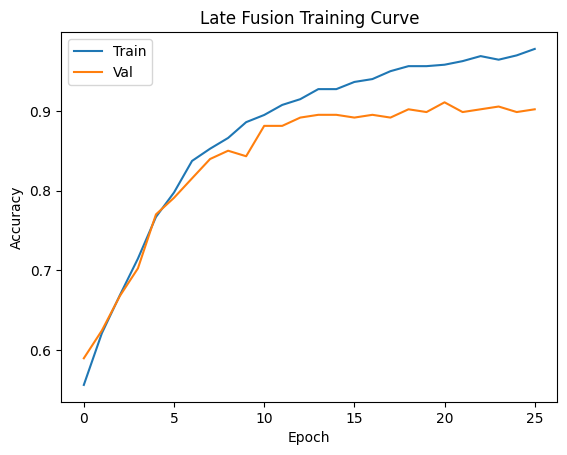

In [33]:
plt.figure()
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Late Fusion Training Curve")
plt.show()

In [34]:
final_val_acc = evaluate(model, val_loader, DEVICE)
print("Final Validation Accuracy:\n", final_val_acc)

Final Validation Accuracy:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.85      0.92        13
           2       0.93      0.96      0.95        73
           4       0.00      0.00      0.00         1
           5       1.00      0.25      0.40         4
           6       0.82      1.00      0.90        14
           8       0.96      1.00      0.98        91
          10       0.00      0.00      0.00         5
          11       1.00      1.00      1.00         8
          13       0.77      1.00      0.87        10
          14       0.67      0.67      0.67         3
          17       0.69      0.95      0.80        19
          18       0.00      0.00      0.00         1
          19       0.50      0.50      0.50         2
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         3
          22       1.00      0.67      0.80         9

/Users/kmn/Documents/NNDL/Project/DepthAware/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kmn/Documents/NNDL/Project/DepthAware/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kmn/Documents/NNDL/Project/DepthAware/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio


Ablation: image_only
Accuracy: 0.8700361010830325

Ablation: depth_only
Accuracy: 0.37545126353790614

Ablation: text_only
Accuracy: 0.7472924187725631

Ablation: image_depth
Accuracy: 0.8700361010830325

Ablation: image_text
Accuracy: 0.9025270758122743

Ablation: depth_text
Accuracy: 0.779783393501805

Ablation: all_modalities
Accuracy: 0.9061371841155235

Ablation Summary:
   image_only   → Accuracy: 0.8700
   depth_only   → Accuracy: 0.3755
   text_only    → Accuracy: 0.7473
   image_depth  → Accuracy: 0.8700
   image_text   → Accuracy: 0.9025
   depth_text   → Accuracy: 0.7798
   all_modalities → Accuracy: 0.9061


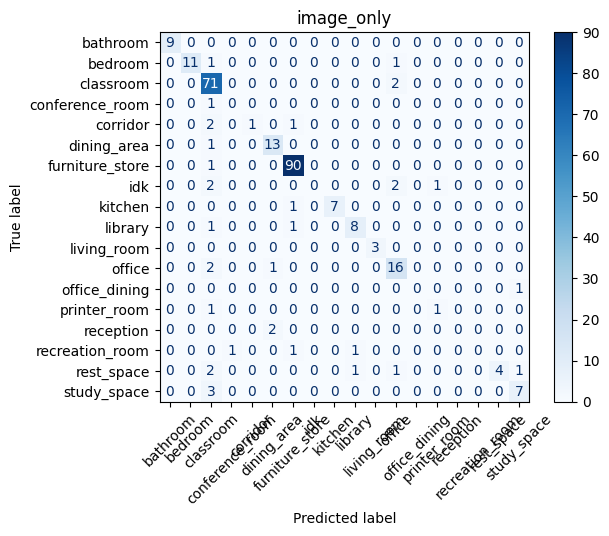

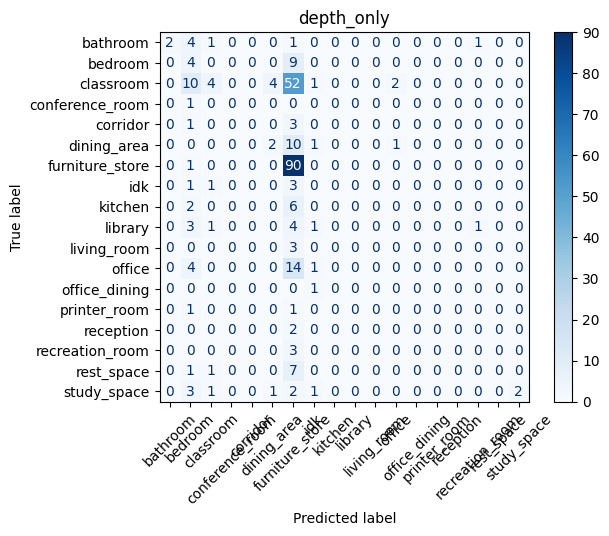

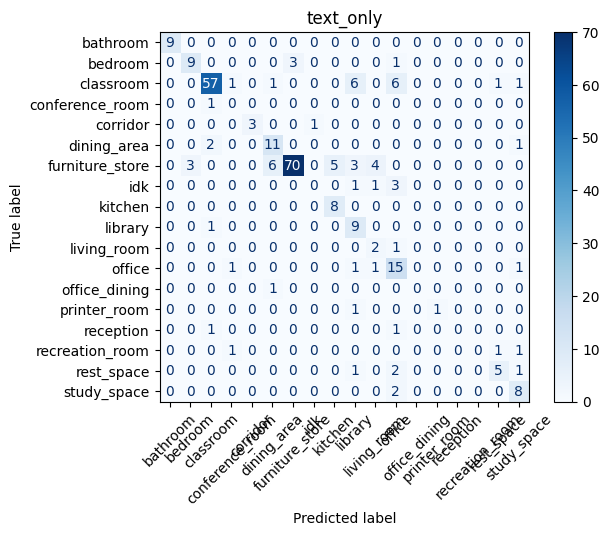

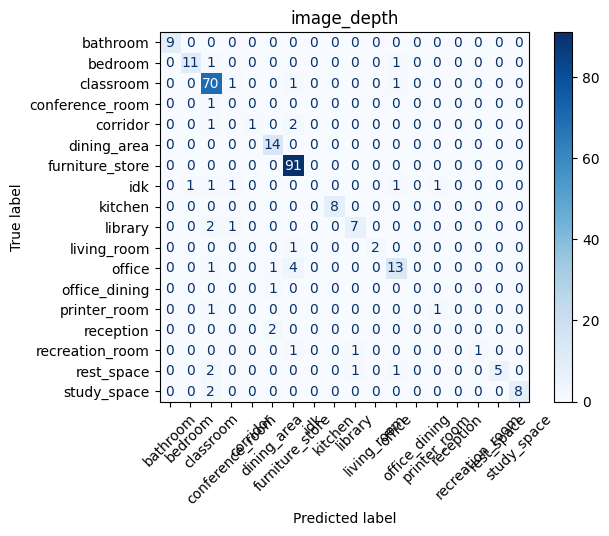

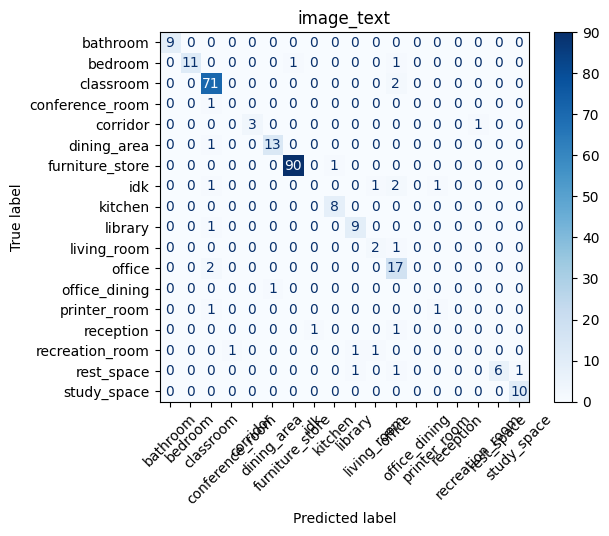

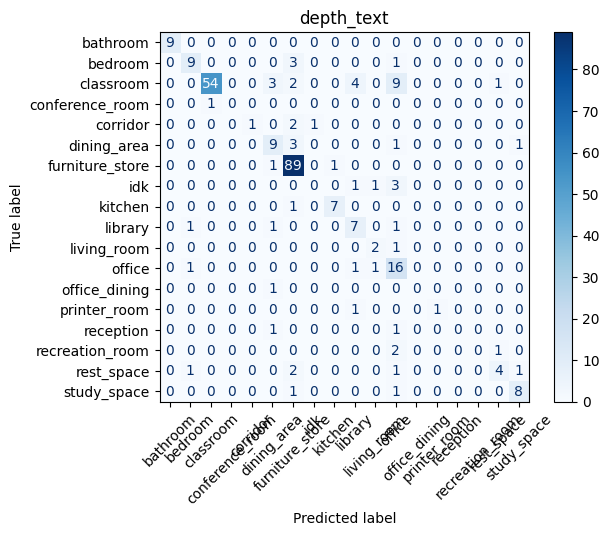

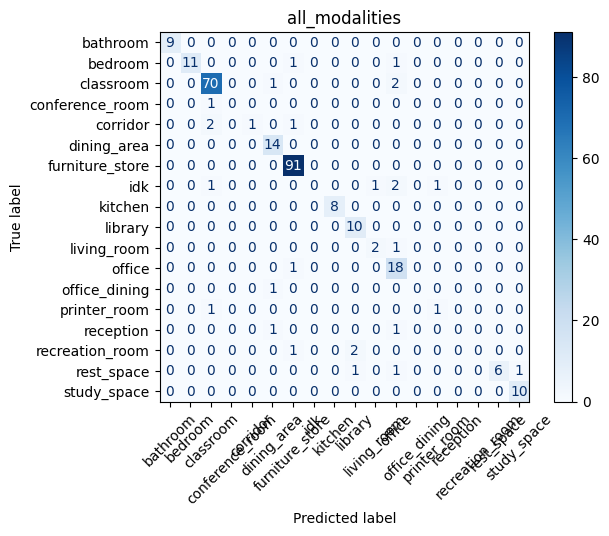

In [ ]:
from sceneclassification.ablations import ABLATION_CONFIGS, evaluate_with_ablation
from sceneclassification.eval import plot_confusion_matrix
import numpy as np

results = {}

for name, ablate in ABLATION_CONFIGS.items():
    print(f"\nAblation: {name}")

    # Evaluate the model with the specified ablation
    out = evaluate_with_ablation(
        model=model,
        dataloader=val_loader,
        device=DEVICE,
        ablate_modalities=ablate,
    )

    results[name] = out["accuracy"]
    print("Accuracy:", out["accuracy"])

    cm = out["confusion_matrix"]
    y_true = out["y_true"]

    # Dynamically determine class labels actually present in this evaluation
    unique_labels = np.unique(y_true)
    class_names = dataset.label_encoder.inverse_transform(unique_labels)

    plot_confusion_matrix(
        cm,
        class_names=class_names,
        title=name,
    )

print("\nAblation Summary:")
for k, v in results.items():
    print(f"   {k:<12} → Accuracy: {v:.4f}")

In [38]:
df_results = pd.DataFrame.from_dict(
    results, orient="index", columns=["accuracy"]
).sort_values("accuracy", ascending=False)

df_results

,accuracy
all_modalities,0.906137
image_text,0.902527
image_only,0.870036
image_depth,0.870036
depth_text,0.779783
text_only,0.747292
depth_only,0.375451
